In [1]:
import sys 
import os
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import astropy.constants as c
import astropy.units as u
from astropy.io import fits
from IPython.display import display
import logging
from pathlib import Path
from datetime import datetime
# import pyregion
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.coordinates import SkyCoord
import importlib
import pickle
import pandas as pd
try:
    logging.getLogger('matplotlib').disabled = True
except:
    pass
import pandas as pd
pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.max_rows', None)
import shutil
from astropy.table import QTable, Table
from matplotlib.patches import (Ellipse, Rectangle)
import matplotlib.patches as mpatches
import itertools
import shapely
import shapely.plotting
from shapely.geometry.point import Point
from shapely import affinity
from scipy.integrate import dblquad
from uncertainties import ufloat
from scipy.optimize import curve_fit
from astropy.visualization import (
    MinMaxInterval, 
    SqrtStretch,
    ImageNormalize,
    simple_norm
)
from astropy import visualization
import matplotlib.cm as cm
from pprint import pprint
import pylustrator
from astropy.stats import sigma_clipped_stats
from astropy.modeling import models
from astropy.convolution.kernels import CustomKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils.utils._parameters import as_pair
from astropy.convolution import discretize_model


In [2]:
ROOT_DIR = os.path.dirname(os.path.realpath('__file__'))
PROG_DIR = os.path.abspath('./mirar')
os.chdir(PROG_DIR)

In [3]:

def test_path(name):
    if isinstance(name,tuple):
        return Path(os.path.abspath(os.path.join(TEST_DIR,*name)))
    else:
        return Path(os.path.abspath(os.path.join(TEST_DIR,name)))
    
def make_test_dirs():
    for dir in OUTPUT_DIRS.values():
        os.makedirs(dir, exist_ok=True)
        
def move_to_raw(path):
    path = Path(path)
    dst = os.path.join(RAW_DIR,path.name)
    shutil.copyfile(path,dst)
    
def prepare(src_dir,src_basenames):
    for file in os.listdir(src_dir):
        for basename in src_basenames:
            if basename in file:
                move_to_raw(os.path.join(src_dir,file)) 
                
def save_params(path):
    with open(path,'w') as file:
        file.write(_ih[-1])
        
DATA_DIR = os.path.join(ROOT_DIR,'SampleData')

TEST_ID = '1'
TEST_DIR = os.path.abspath(os.path.join(ROOT_DIR,'test_'+TEST_ID))
OUTPUT_DIRS = {
    'BKG': test_path('background'),
    'DET': test_path('detection'),
    'PSF_MODEL': test_path('psf_model'),
    'PHOTCAL': test_path('photcal'),
    'PSF_PHOT': test_path('psf_phot'),
    'APER_PHOT': test_path('aper_phot'),
    'LOG': test_path('log'),
    'CONF': test_path('config'),
    'RES': test_path('results'),
    'CAT': test_path('catalogs'),
    'XMAT': test_path('xmatch'),
    'SEE': test_path('seeing'),
}
make_test_dirs()

RAW_DIR = os.path.join(TEST_DIR,'raw')
os.makedirs(RAW_DIR, exist_ok=True)

LOGGING = True
LOG_FILE = os.path.abspath(os.path.join(OUTPUT_DIRS['LOG'],f"test{TEST_ID}_{datetime.now()}"))
if LOGGING:
    logger = logging.getLogger(__name__)
    logging.basicConfig(filename=LOG_FILE,level=logging.DEBUG)
    logging.getLogger('matplotlib').disabled = True

ENV = {
    'RAW_DATA_DIR': RAW_DIR,
    'OUTPUT_DATA_DIR': TEST_DIR,
    'REF_IMG_DIR': '',
    'USE_WINTER_CACHE': 'false',
    'FRITZ_TOKEN': 'test',
    'KOWALSKI_TOKEN': 'test',
    'DB_USER': 'postgres',
    'DB_PWD': '',
}
for var in ENV.keys():
    os.environ[var] = ENV[var]

In [4]:
class Fits:
    def __init__(self, file, print_=True):
        self.file = file
        self.data = {}
        self.header = {}
        open_file = fits.open(self.file)
        if print_:
            open_file.info()
        open_file.close()
        self.read()
        try:
            logging.getLogger("matplotlib").disabled = True
        except:
            pass

    def read(self, hdu=0):
        open_file = fits.open(self.file)
        try:
            self.data[hdu] = open_file[hdu].data.astype(float)
        except (AttributeError, TypeError, ValueError):
            print(rf"HDU {hdu} is not float")
            self.data[hdu] = open_file[hdu].data

        self.header[hdu] = open_file[hdu].header
        open_file.close()

    def wcs_plot(self, hdu=0):
        wcs = WCS(self.header[hdu])
        fig = plt.figure(clear=True)
        ax = plt.subplot(projection=wcs)
        fig.add_axes(ax)
        return fig, ax

    def create_copy(self):
        shutil.copy2(self.file, f"{self.file}.copy")

    def image(
        self,
        hdu=0,
        column=False,
        title=None,
        scale=[5, 95],
        save=False,
        tag=None,
        wcs=False,
        median=True,
        meanstd=True,
    ):
        data = self.data[hdu]
        if column:
            data = data[column]
        if not wcs:
            fig, ax = plt.subplots()
            ax.set_xlabel("x pixel")
            ax.set_ylabel("y pixel")
        else:
            wcs_ = WCS(self.header[hdu])
            fig = plt.figure(clear=True)
            ax = plt.subplot(projection=wcs_)
            fig.add_axes(ax)
        self.ax = ax
        if not meanstd and scale:
            try:
                if median:
                    img = np.nanmedian(data, axis=1)
                else:
                    img = data
            except np.AxisError:
                print("invalid shape", data.shape)
                return
            self.scale_low, self.scale_high = np.percentile(img, scale)
            im = ax.imshow(
                data, cmap="magma", vmin=self.scale_low, vmax=self.scale_high
            )
        elif meanstd:
            mean, std = np.nanmean(data), np.nanstd(data)
            vmin = mean - std
            vmax = mean + 10 * std
            im = ax.imshow(
                data,
                interpolation="nearest",
                cmap="gray",
                vmin=vmin,
                vmax=vmax,
                origin="lower",
                # norm=mcolors.Normalize(vmin=vmin,vmax=vmax)
            )
        else:
            im = ax.imshow(data, cmap="magma")
        fig.colorbar(im, ax=ax , pad=0.005)
        if not title:
            title = rf"{os.path.basename(os.path.dirname(self.file))}/{os.path.basename(self.file)}"
        ax.set_title(title)
        if save:
            if tag:
                fig.savefig(
                    os.path.join(
                        os.path.dirname(self.file),
                        rf"{os.path.basename(self.file)}_{tag}.png",
                    ),
                    dpi=600,
                )
            else:
                fig.savefig(
                    os.path.join(
                        os.path.dirname(self.file),
                        rf"{os.path.basename(self.file)}.png",
                    ),
                    dpi=600,
                )
        fig.tight_layout()
        return ax

    def image_with_reg(
        self, reg, hdu=0, wcsaxis=[0.1, 0.1, 0.8, 0.8], v=[0, 100], save=False, tag=None
    ):
        r = pyregion.open(reg).as_imagecoord(self.header[hdu])
        patch_list, artist_list = r.get_mpl_patches_texts()
        wcs = WCS(self.header[hdu])
        fig = plt.figure(clear=True)
        ax = plt.subplot(projection=wcs)
        # ax = WCSAxes(fig,wcsaxis,wcs=wcs)
        fig.add_axes(ax)
        for p in patch_list:
            p.set_color("red")
            p.set_facecolor("none")
            ax.add_patch(p)
        for t in artist_list:
            ax.add_artist(t)

        if v:
            im = ax.imshow(
                self.data[0], origin="lower", vmin=v[0], vmax=v[1], cmap="magma"
            )
        else:
            im = ax.imshow(self.data[0], origin="lower", cmap="magma")
        fig.colorbar(im, cmap="magma")
        if save:
            if tag:
                fig.savefig(
                    os.path.join(
                        os.path.dirname(self.file),
                        rf"{os.path.basename(self.file)}_{tag}.reg.png",
                    ),
                    dpi=600,
                )
            else:
                fig.savefig(
                    os.path.join(
                        os.path.dirname(self.file),
                        rf"{os.path.basename(self.file)}.reg.png",
                    ),
                    dpi=600,
                )
        # fig.show()
        return ax

    def bin_table(self, hdu=0, return_=True, save=False):
        df = pd.DataFrame(self.data[hdu])
        if save:
            df.to_csv(
                os.path.join(
                    os.path.dirname(self.file), rf"{os.path.basename(self.file)}.csv"
                ),
                encoding="utf-8",
            )
        if return_:
            return df
        else:
            return None

    def bin_table2(self, hdu=0):
        table = QTable(self.data[hdu])
        return table

    def mark_from_cat(self, keys, cat_file=None, cat_table=None, hdu=2, save=False, color='red'):
        x_offset = 2
        y_offset = 2
        if cat_file:
            catfits = Fits(cat_file)
            catfits.read(hdu)
            cat = catfits.bin_table2(hdu)
        elif isinstance(cat_table,QTable) or isinstance(cat_table,pd.DataFrame):
            cat = cat_table
        else:
            return
        shape = (self.ax.get_xlim()[-1], self.ax.get_ylim()[-1])
        for i, (x, y, a, b, theta) in enumerate(
            zip(
                cat[keys["x"]],
                cat[keys["y"]],
                cat[keys["a"]],
                cat[keys["b"]],
                cat[keys["angle"]],
            )
        ):
            marker = Ellipse(xy=(x,y), height=a, width=b, angle=theta-90, color=color, fill=None) # theta-90 to rotate wrt. x
            self.ax.add_patch(marker)
            annotation = str(i)
            try:
                if 'NUMBER' in list(cat.columns):
                    annotation = cat['NUMBER'][i]
            except:
                print('could not access column names')
            if x + x_offset >= shape[0] - x_offset * 2:
                self.ax.annotate(
                    annotation, (x - x_offset*2, y + y_offset), color=color
                )
            else:
                self.ax.annotate(annotation, (x + x_offset, y + y_offset), color=color)
        if save:
            plt.savefig(cat_file+'.png',dpi=300)


def mark_from_cat(ax, keys, cat_file=None, cat_table=None, hdu=2, save=False, color='red', condition=True,bound=False,bounds=None,annotate=True):
    x_offset = 2
    y_offset = 2
    if cat_file:
        catfits = Fits(cat_file)
        catfits.read(hdu)
        cat = catfits.bin_table2(hdu)
    elif isinstance(cat_table,QTable) or isinstance(cat_table,pd.DataFrame):
        cat = cat_table
    else:
        return
    shape = (ax.get_xlim()[-1], ax.get_ylim()[-1])
    
    pos_all = []
    for i, (x, y, a, b, theta) in enumerate(
        zip(
            cat[keys["x"]],
            cat[keys["y"]],
            cat[keys["a"]],
            cat[keys["b"]],
            cat[keys["angle"]],
        )
    ):
        if condition:
            if not bound or bound and (x>=bounds[0][0] and x<=bounds[0][1] and y>=bounds[1][0] and y<=bounds[1][1]):
                marker = Ellipse(xy=(x,y), height=a, width=b, angle=theta-90, color=color, fill=None) # theta-90 to rotate wrt. x
                ax.add_patch(marker)
                annotation = str(i)
                if annotate:
                    try:
                        if 'NUMBER' in list(cat.columns):
                            annotation = cat['NUMBER'][i]
                    except:
                        print('could not access column names')
                    if x + x_offset >= shape[0] - x_offset * 2:
                        ax.annotate(
                            annotation, (x - x_offset*2, y + y_offset), color=color
                        )
                    else:
                        ax.annotate(annotation, (x + x_offset, y + y_offset), color=color)
                pos_all.append([x,y])
    return pos_all

In [5]:
def load_object(path):
    with open(path,'rb') as file:
        return pickle.load(file)

def presentation(file):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))  # Adjust size as per your need

    # image_paths = 

    for ax, image_path in zip(axs.flatten(), file):
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off') 

    # Adjusting subfig positions
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    plt.show()



file_list = os.listdir(RAW_DIR)

file = file_list[0]
# presentation(file)

In [17]:
file_list = os.listdir(RAW_DIR)
file_unmatched = []
for i in range(0,200):
    try:
        load_object(Path(OUTPUT_DIRS['SEE']).joinpath(file_list[i].replace('.fits','_sources.pkl'))).get_data()
    except:
        file_unmatched.append(i)
len(file_unmatched)
print(file_unmatched)

[0, 1, 3, 6, 8, 9, 11, 12, 17, 18, 23, 26, 27, 28, 29, 31, 32, 35, 36, 39, 42, 43, 44, 45, 48, 49, 53, 56, 57, 58, 65, 67, 72, 73, 74, 76, 83, 84, 85, 87, 90, 96, 98, 101, 103, 105, 107, 109, 115, 116, 119, 124, 125, 126, 132, 134, 135, 136, 137, 144, 146, 149, 150, 151, 155, 157, 159, 160, 161, 163, 164, 165, 166, 168, 171, 173, 180, 181, 182, 185, 189, 192, 195, 196, 198, 199]


OBK-549088-WiFeS-Acq--UT20231031T095750-7.fits


[]

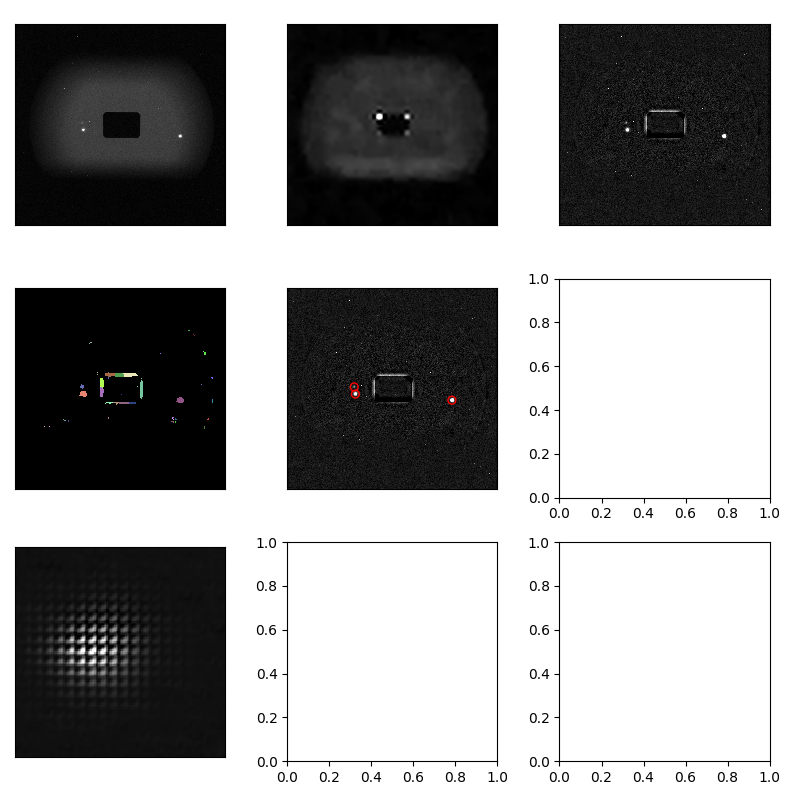

In [19]:

# import pylustrator
# pylustrator.start()


# num = 198
# num = 100
# num = 50
num = 5

file_list = os.listdir(RAW_DIR)
file = file_list[num]
print(file)



paths = [
    os.path.join(RAW_DIR, file),
    os.path.join(OUTPUT_DIRS['BKG'], file+'.background_rms'),
    os.path.join(OUTPUT_DIRS['BKG'], file),
]


fig, axs = plt.subplots(3, 3, figsize=(8,8), tight_layout=True)

for i, path in enumerate(paths):
    data = fits.getdata(path)
    mean, std = np.nanmean(data), np.nanstd(data)
    vmin = mean - std
    vmax = mean + 10 * std
    ax = axs[i//3,i%3]
    im = ax.imshow(
        data,
        interpolation="nearest",
        cmap="gray",
        vmin=vmin,
        vmax=vmax,
        origin="lower",
        # norm=mcolors.Normalize(vmin=vmin,vmax=vmax)
    )
    ax.set_yticks([])
    ax.set_xticks([])
    # fig.colorbar(im, ax=axs[i//3,i%3] , pad=0.005, shrink=0.8)



segm = fits.getdata(os.path.join(OUTPUT_DIRS['DET'], file +'.segm'))
# cmap = load_object(os.path.join(OUTPUT_DIRS['DET'], file +'.segm.cmap.pkl'))
cmap = load_object('/Users/astqx/Desktop/WiFeS/WiFeS_seeing/test_0/detection/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits.segm.cmap.pkl')


# mean, std = np.nanmean(data), np.nanstd(data)
# vmin = mean - std
# vmax = mean + 10 * std
ax = axs[1,0]
ax.imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
ax.set_yticks([])
ax.set_xticks([])

# xmatch

# cat_file = os.path.join(OUTPUT_DIRS['XMAT'],file.replace('fits','gaiadr3.cat'))
# cat_fits = Fits(cat_file)
# cat_table = cat_fits.bin_table2()

# cat_table = load_object(os.path.join(OUTPUT_DIRS['SEE'], file.replace('.fits','_sources.pkl'))).get_data()
cat_table = load_object(Path(OUTPUT_DIRS['SEE']).joinpath(file.replace('.fits','_sources.pkl'))).get_data()

SRC_KEYS = {
    'x': 'xcentroid',
    'y': 'ycentroid',
    'a': 'a',
    'b': 'a',
    'angle': 'theta'
}

cat_table['a'] = np.ones(len(cat_table))*20
cat_table['b'] = np.ones(len(cat_table))*20
cat_table['theta'] = np.zeros(len(cat_table))

data = fits.getdata(paths[2])
mean, std = np.nanmean(data), np.nanstd(data)
vmin = mean - std
vmax = mean + 10 * std
ax = axs[1,1]

im = ax.imshow(
    data,
    interpolation="nearest",
    cmap="gray",
    vmin=vmin,
    vmax=vmax,
    origin="lower",
    # norm=mcolors.Normalize(vmin=vmin,vmax=vmax)
)
ax.set_yticks([])
ax.set_xticks([])

mark_from_cat(
    ax,
    SRC_KEYS,
    cat_table=cat_table,
    annotate=False,
)

# psf model

# data = fits.getdata(os.path.join(OUTPUT_DIRS['PSF_MODEL'], file[:-5]+'.psfmodel.fits'))
data = load_object(os.path.join(OUTPUT_DIRS['PSF_MODEL'], file[:-5]+'.psfmodel.pkl')).data
crop = data.shape[0]//4
data = data[crop:-crop,crop:-crop]

mean, std = np.nanmean(data), np.nanstd(data)
vmin = mean - std
vmax = mean + 10 * std
ax = axs[2,0]
ax.imshow(
    data,
    interpolation="nearest",
    cmap="gray",
    vmin=vmin,
    vmax=vmax,
    origin="lower",
    # norm=mcolors.Normalize(vmin=vmin,vmax=vmax)
)
ax.set_yticks([])
ax.set_xticks([])








# fig.tight_layout()

# title = rf"{os.path.basename(os.path.dirname(self.file))}/{os.path.basename(self.file)}"
# ax.set_title(title)




            

        


In [8]:
os.path.join(OUTPUT_DIRS['DET'], file +'.segm')

'/home/mf/Desktop/Courses/Summner-Intership-2024/WiFeS_seeing/test_0/detection/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits.segm'

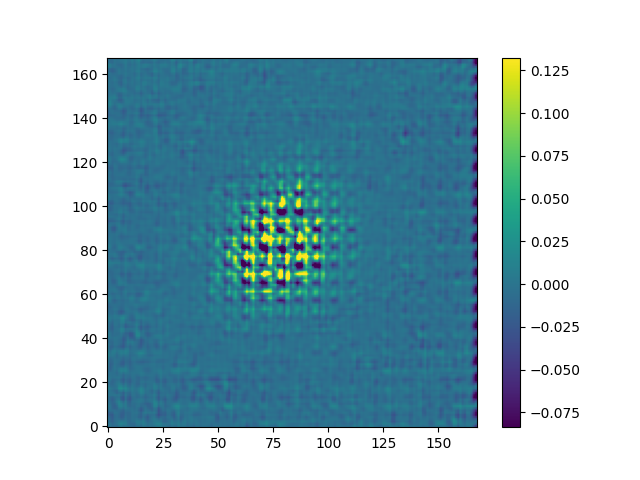

In [9]:
psfmodel = load_object('/home/mf/Desktop/Courses/Summner-Intership-2024/WiFeS_seeing/test_0/psf_model/OBK-530784-WiFeS-Acq--UT20231008T093800-5.psfmodel.pkl')

prec = 8
size = 21*prec
x, y = np.mgrid[0:size, 0:size]/prec
center = (size//2/prec,size//2/prec)

psf_array = psfmodel.evaluate(x,y,1,*center)

norm = simple_norm(psf_array, 'power', percent=99.0)

plt.figure(clear=True)
plt.imshow(psf_array, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
plt.show()


In [10]:
data = load_object('/home/mf/Desktop/Courses/Summner-Intership-2024/WiFeS_seeing/test_0/psf_model/OBK-530784-WiFeS-Acq--UT20231008T093800-5.fits.cutouts.fitted.pkl')
data